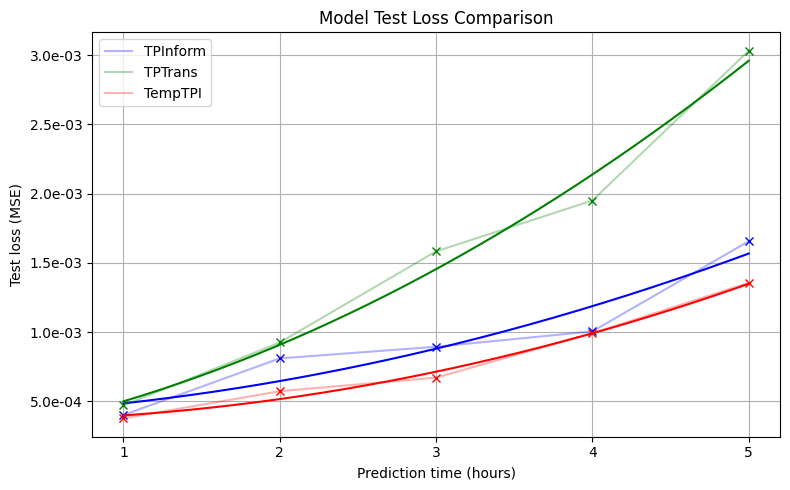

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from scipy.optimize import curve_fit

# Read the CSV file
df = pd.read_csv("results_large_data.csv", sep=",", engine="python")

# Clean column names and remove trailing semicolons if present
df["test_loss"] = df["test_loss"].astype(float)
df["model"] = df["model"].astype(str)

def f_quad(x, a, b, c):  return a*x**2 + b*x + c

# Plot
plt.figure(figsize=(8, 5))
colors = ["b","g","r"]
for col, (model, group) in zip(colors, df.groupby("model")):
    # Fit curve
    x = np.arange(1, len(group) + 1)
    y = group["test_loss"].values
    popt, _ = curve_fit(f_quad, x, y, maxfev=10000)
    # Smooth curve for visualization
    x_smooth = np.linspace(1, len(group), 200)
    y_smooth = f_quad(x_smooth, *popt)

    # Plot real data
    plt.plot(x, y, alpha=0.3, label=f"{model}", c=col)
    plt.plot(x, y, "x", c=col)
    # Plot fitted curve
    plt.plot(x_smooth, y_smooth, alpha=1, c=col)

plt.xlabel("Prediction time (hours)")
plt.ylabel("Test loss (MSE)")
plt.title("Model Test Loss Comparison")
plt.legend()
plt.xticks(range(1,6))
plt.yticks([x*5/10000 for x in range(1,7)])
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
plt.grid(True, which="major")
plt.tight_layout()
plt.show()